In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
import sys
sys.path.append('../')
from utils import step_schedule_exp_decay as exp_decay_imported
from helpers import load_dict
from plotting_helpers import add_gridlines, add_energy_legends

In [3]:
from scipy.optimize import curve_fit

In [4]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"


plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"
})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)
bigger_font_size=22


## Helper Functions

In [5]:
def fourth_order(x, c1, c2, c3, c4, cy):
    return cy + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4
def fourth_order_only(x, c4, cy):
    return cy + c4 * x**4

# Load Data

In [6]:
scales = [1.,2.,4.]
rates = [0.158,0.25,0.475]

Ls_all = np.arange(6,31,6)

In [7]:
run_times = load_dict('./plotting_data/runtimes_data.pkl')

In [8]:
rate_markers={0.158:'*',0.25:'H',0.475:'^'}
rate_lines={0.158:':',0.25:'--',0.475:'-'}
rate_alphas={0.475:0.2,0.25:0.5,0.158:0.9}
rate_markersize={0.158:9,0.25:7,0.475:7}

colorscale_sq = plt.get_cmap('plasma')
colorscale_tri = plt.get_cmap('viridis')
shades = np.linspace(0.,0.9,2*len(scales))[::-2]
colors_sq = colorscale_sq(shades)
colors_tri = colorscale_tri(shades)
scale_shades = {'Square':{1.0:colors_sq[-3],2.0:colors_sq[-2],4.0:colors_sq[-1]},
                'Triangular':{1.0:colors_tri[-3],2.0:colors_tri[-2],4.0:colors_tri[-1]}}

# Number of training steps

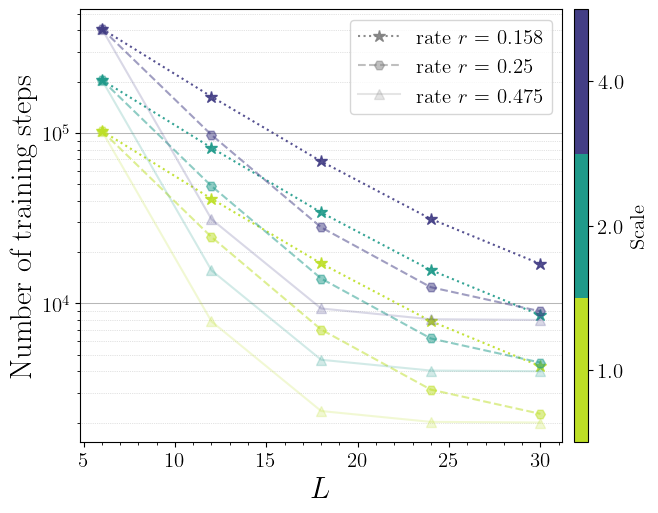

In [9]:
fig, ax = plt.subplots(figsize=square_fig_size)
ms = 'Triangular'

for rate_i,rate in enumerate(rates[:]):
    for scale_i,scale in enumerate(scales):
        if (scale==8.0) & (rate==0.158):
            continue
        plot_Ls = []
        steps_per_L = []
        for L_i,L in enumerate(Ls_all):
            plot_Ls.append(L)
            steps = exp_decay_imported(L,scale=scale,rate=rate)
            steps_rounded = int(np.floor(steps/100)*100)
            steps_per_L.append(steps)

            total_steps = np.sum(np.array(steps_per_L))
        
        plt.errorbar(plot_Ls,steps_per_L,color=scale_shades[ms][scale],
                        alpha=rate_alphas[rate],
                        markersize=rate_markersize[rate],marker=rate_markers[rate],linestyle=rate_lines[rate])

add_gridlines(axes='y')
add_energy_legends(show_runs=True)

plt.ylabel("Number of training steps",fontsize=bigger_font_size)
plt.xlabel("$L$",fontsize=bigger_font_size)
plt.yscale('log')

plt.savefig('./final_figures/num_training_steps.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

# Time per step

In [10]:
which_bc = 'periodic'
rate = 0.475
scale = 1.0
plot_ls = []
plot_times = []
open_plot_times = []

for l_i, key in enumerate(run_times.keys()):
    print(key)
    if l_i>=5:
        continue
    if 'mean time per step' in run_times[key].keys():
        plot_ls.append(Ls_all[l_i])
        plot_times.append(run_times[key]['mean time per step'])
        print(f"For {key}, run time = {run_times[key]['mean time per step']}")


L=6
For L=6, run time = 0.2776134095354405
L=12
For L=12, run time = 3.662018906855153
L=18
For L=18, run time = 18.18860294154746
L=24
For L=24, run time = 57.72434663103673
L=30
For L=30, run time = 137.4104113349456
L=36


4th order only
coeff for fourth order: 0.00016965927412155337
intercept:              0.40040439990597626
full fit
coeff for first order:  1.573232372548725
coeff for second order:  -0.1788253424684874
coeff for third order:  0.008241921691302962
coeff for fourth order: 4.096515696367938e-05
intercept:              -4.55741442563773


/Users/megan/miniconda3/envs/HeisenbergRNN/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


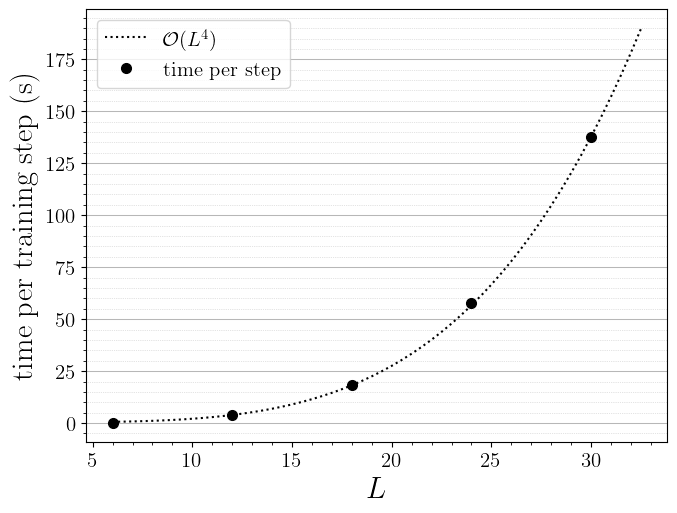

In [11]:
fig,ax = plt.subplots(figsize=square_fig_size)

plot_ls_np = np.array(plot_ls)
plot_times_np = np.array(plot_times)

plt.errorbar(plot_ls_np,plot_times_np,markersize=7,label='time per step',color='k',fmt='o')

params, covariance = curve_fit(fourth_order, plot_ls_np, plot_times_np)
params_4only, covariance = curve_fit(fourth_order_only, plot_ls_np, plot_times_np)
x_mesh = np.arange(min(plot_ls_np),1.1*max(plot_ls_np),0.5)
plt.plot(x_mesh,fourth_order_only(x_mesh,params_4only[0],params_4only[1]),color='k',linestyle=':',label='$\mathcal{O}(L^4)$')

print("4th order only")
print(f"coeff for fourth order: {params_4only[0]}")
print(f"intercept:              {params_4only[1]}")
print("full fit")
print(f"coeff for first order:  {params[0]}")
print(f"coeff for second order:  {params[1]}")
print(f"coeff for third order:  {params[2]}")
print(f"coeff for fourth order: {params[3]}")
print(f"intercept:              {params[4]}")

add_gridlines(axes='y')

plt.xlabel("$L$",fontsize=bigger_font_size)
plt.ylabel("time per training step (s)",fontsize=bigger_font_size)
plt.legend()

plt.savefig('./final_figures/time_per_L.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

# Run times

Estimated run time for 1.0,0.158 = 426.07515077169637 GPU hours
Estimated run time for 1.0,0.25 = 204.35105951101895 GPU hours
Estimated run time for 1.0,0.475 = 136.4783854037206 GPU hours
Estimated run time for 2.0,0.158 = 849.1559627273774 GPU hours
Estimated run time for 2.0,0.25 = 407.8818417575539 GPU hours
Estimated run time for 2.0,0.475 = 272.81055199854785 GPU hours
Estimated run time for 4.0,0.158 = 1695.3346384069448 GPU hours
Estimated run time for 4.0,0.25 = 814.9322533836754 GPU hours
Estimated run time for 4.0,0.475 = 545.4868845667013 GPU hours


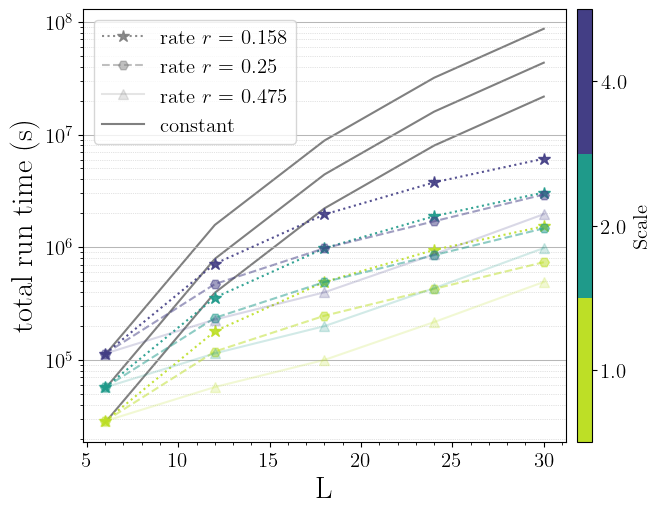

In [12]:
fig, ax = plt.subplots(figsize=square_fig_size)
ms = 'Triangular'

for scale_i,scale in enumerate(scales):
    for rate in rates[:]:
        if (scale==8.0) & (rate==0.158):
            continue
        decay = np.array([exp_decay_imported(l,scale=scale,rate=rate) for l in plot_ls_np])
        decay_runtimes = []
        num_steps_prev = 0
        amt_run_time_prev = 0
        for l_i,l in enumerate(plot_ls_np):
            num_new_steps = decay[l_i] 
            new_run_time = num_new_steps * plot_times[l_i]
            decay_runtimes.append(amt_run_time_prev + new_run_time)
            num_steps_prev += num_new_steps
            amt_run_time_prev += new_run_time
            if l==30:
                print(f"Estimated run time for {scale},{rate} = {amt_run_time_prev/(60*60)} GPU hours")

        plt.plot(plot_ls_np,decay_runtimes,color=scale_shades[ms][scale],
                 alpha=rate_alphas[rate],markersize=rate_markersize[rate],
                 marker=rate_markers[rate],linestyle=rate_lines[rate],
                label=f'rate={rate}, scale={scale}',)
        
    no_decay_scale = 100000 * scale
    no_decay_scale_runtimes = []
    num_steps_prev = 0
    amt_run_time_prev = 0
    for l_i,l in enumerate(plot_ls_np):
        num_new_steps =no_decay_scale
        new_run_time = num_new_steps * plot_times[l_i]
        no_decay_scale_runtimes.append(amt_run_time_prev + new_run_time)
        num_steps_prev += num_new_steps
        amt_run_time_prev += new_run_time

    plt.plot(plot_ls_np,no_decay_scale_runtimes,color='grey',label=f'constant,scale={scale}',zorder=-1)
    
add_gridlines(axes='y')
add_energy_legends(show_runs=True,show_const=True)

plt.yscale('log')
plt.ylabel("total run time (s)",fontsize=bigger_font_size)
plt.xlabel("L",fontsize=bigger_font_size)

plt.savefig('./final_figures/run_times.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()